<a href="https://colab.research.google.com/github/austiezr/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [518]:
df_processed = df.drop(['diagnosis', 'Unnamed: 32', 'id'], axis=1)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 non-null float64
symmetry_se                569 

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


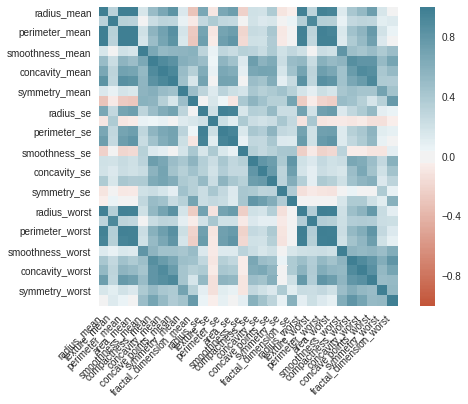

In [519]:
ax = sns.heatmap(
    df_processed.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [520]:
# Perform K-Means Clustering on the Dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_test = df_processed[['concavity_mean', 'compactness_mean']]

kmeans = KMeans(4).fit(df_test)

labels = kmeans.labels_

labels

array([2, 3, 1, 2, 1, 1, 3, 3, 1, 1, 0, 3, 1, 3, 1, 1, 0, 1, 3, 0, 3, 0,
       1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 3, 0, 3, 1, 3,
       3, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 0, 1, 0, 3, 3,
       0, 0, 2, 0, 3, 3, 1, 3, 0, 3, 3, 1, 2, 0, 0, 3, 2, 1, 0, 3, 3, 3,
       0, 3, 0, 3, 0, 0, 1, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 2, 0,
       0, 3, 2, 3, 0, 0, 3, 1, 1, 0, 0, 3, 2, 3, 0, 0, 0, 3, 3, 1, 0, 3,
       3, 3, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 1, 3, 3, 0, 0, 3, 2, 0,
       3, 0, 1, 0, 0, 0, 3, 3, 1, 0, 3, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0,
       3, 1, 0, 0, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3, 1, 0, 3, 3,
       3, 3, 0, 3, 2, 1, 3, 3, 0, 0, 3, 0, 1, 0, 2, 3, 3, 3, 3, 0, 3, 3,
       0, 3, 0, 3, 0, 0, 0, 3, 0, 1, 1, 0, 0, 3, 0, 0, 1, 3, 3, 3, 0, 0,
       3, 0, 1, 0, 0, 3, 0, 0, 1, 0, 1, 3, 3, 3, 1, 1, 2, 1, 3, 0, 3, 0,
       3, 3, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 3, 0,
       3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [521]:
# Your Code Here
df['diagnosis'] = df['diagnosis'].map({'B' : 0, 'M' : 1})
df['diagnosis'].head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [522]:
print(df['diagnosis'].value_counts())
print(np.bincount(labels))
print(np.unique(labels))

0    357
1    212
Name: diagnosis, dtype: int64
[294  84  22 169]
[0 1 2 3]


In [523]:
new_series = pd.Series(labels)
df_test['clusters'] = new_series.values
df_test['diagnosis'] = df['diagnosis']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


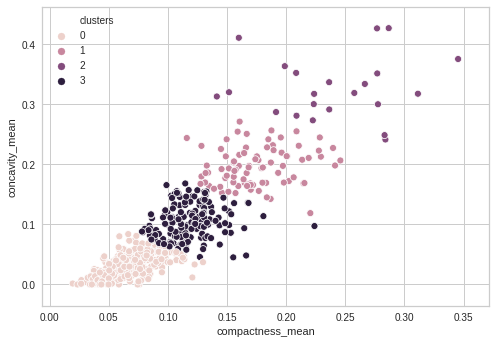

In [524]:
sns.scatterplot(df_test['compactness_mean'], df_test['concavity_mean'], hue=df_test['clusters'])

In [525]:
num_correct = np.bincount(labels)[0]
num_total = 569
print(num_correct / num_total)

0.5166959578207382


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



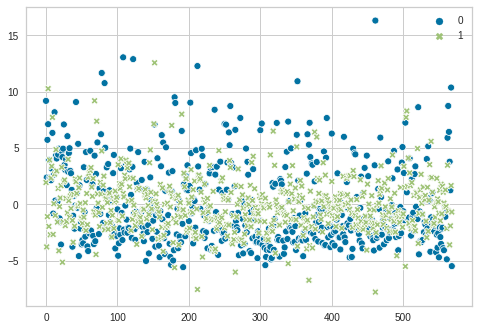

In [526]:
scaler = StandardScaler()
df_processed = scaler.fit_transform(df_processed)
df_processed = pd.DataFrame(df_processed)

pca = PCA(2)
pca_features = pca.fit_transform(df_processed)
sns.scatterplot(data=pca_features)

In [0]:
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [0]:
pca = PCA()
pca_features = pca.fit_transform(df_processed)

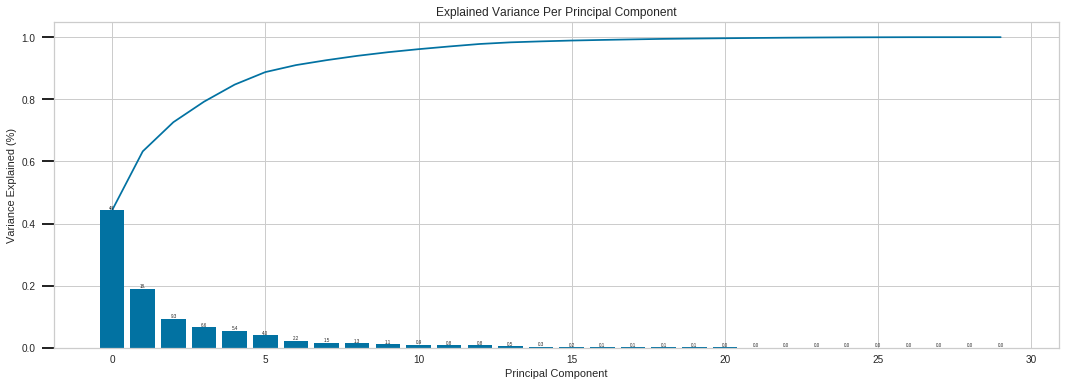

In [529]:
scree_plot(pca)

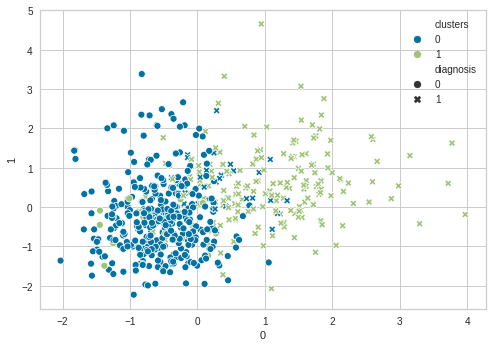

In [530]:
df_test_two = df_processed.copy()

kmeans = KMeans(2).fit(pca_features)

labels = kmeans.labels_

new_series = pd.Series(labels)
df_test_two['clusters'] = new_series.values
df_test_two['diagnosis'] = df['diagnosis']

sns.scatterplot(df_test_two[0], df_test_two[1], hue=df_test_two['clusters'], style=df_test_two['diagnosis'])

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

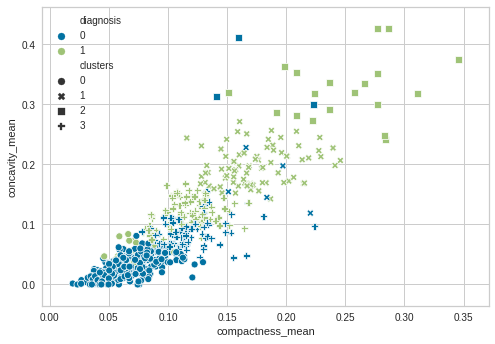

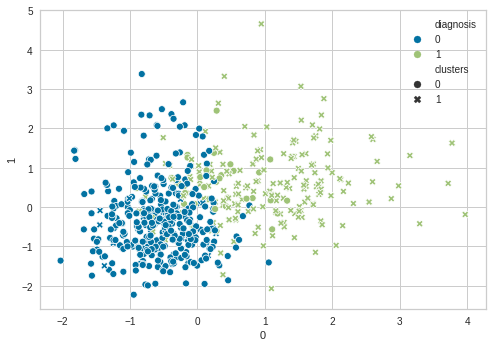

In [531]:
sns.scatterplot(df_test['compactness_mean'], df_test['concavity_mean'], hue=df_test['diagnosis'], style=df_test['clusters'])

plt.show()

sns.scatterplot(df_test_two[0], df_test_two[1], hue=df_test_two['diagnosis'], style=df_test_two['clusters'])

plt.show()

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project